In [ ]:
from plot_utils import plot_coordination_histograms, plot_graph_structure, plot_cluster_size_distribution, plot_cluster_composition_analysis, plot_3d_cluster_visualization, plot_3d_cluster_with_graph, analyze_bond_network, plot_rdfs


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import freud
from ase.io import read
import glob
import re
from pathlib import Path


/global/u2/p/pvashi/.conda/envs/metaml/lib/python3.11/site-packages/freud/diffraction.py:20: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  import scipy.ndimage


In [2]:
def build_voronoi_graph(atoms, min_area=0.0):
    """
    Build a graph using Voronoi tessellations instead of RDF bonds.
    
    Parameters:
        atoms: ASE atoms object
        min_area: Minimum facet area threshold for Voronoi neighbors
    
    Returns:
        networkx.Graph: Graph with atoms as nodes and Voronoi neighbors as edges
    """
    assert atoms.pbc.all(), "freud Voronoi expects PBC in all directions."
    
    # Create freud box and compute Voronoi tessellation
    box = freud.box.Box.from_matrix(atoms.get_cell().array)
    positions = atoms.get_positions()
    species = atoms.get_chemical_symbols()
    
    v = freud.locality.Voronoi()
    v.compute((box, positions))
    
    # Create networkx graph
    G = nx.Graph()
    
    # Add nodes with atom properties
    for i, (pos, spec) in enumerate(zip(positions, species)):
        G.add_node(i, position=pos, species=spec, index=i)
    
    # Add edges based on Voronoi neighbors
    i_indices = v.nlist[:, 0]
    j_indices = v.nlist[:, 1]
    areas = v.nlist.weights
    
    # Filter by minimum area threshold
    mask = areas >= min_area
    i_filtered = i_indices[mask]
    j_filtered = j_indices[mask]
    areas_filtered = areas[mask]
    
    # Add edges with facet area as edge weight
    for i, j, area in zip(i_filtered, j_filtered, areas_filtered):
        G.add_edge(i, j, area=area, 
                   species_pair=f"{species[i]}-{species[j]}")
    
    return G


In [3]:
def analyze_voronoi_coordination(atoms_list, at_list=None, min_area=0.0):
    """
    Analyze coordination using Voronoi tessellations (adapted from report_count_voronoi.ipynb).
    
    Parameters:
        atoms_list: List of ASE atoms objects
        at_list: List of atomic species to consider
        min_area: Minimum facet area threshold
    
    Returns:
        dict: Coordination data organized by central species and neighbor species
    """
    # Build species universe
    if at_list is None:
        all_species = sorted({s for at in atoms_list for s in at.get_chemical_symbols()})
    else:
        all_species = list(at_list)
    sp2idx = {sp: i for i, sp in enumerate(all_species)}

    # Output structure: for each central species, a list of neighbor counts per neighbor species
    coord_data = {sp_c: {sp_n: [] for sp_n in all_species} for sp_c in all_species}

    for atoms in tqdm(atoms_list):
        assert atoms.pbc.all(), "freud Voronoi expects PBC in all directions."
        box = freud.box.Box.from_matrix(atoms.get_cell().array)
        pos = atoms.get_positions()
        species = np.array(atoms.get_chemical_symbols())
        species_idx = np.array([sp2idx[s] for s in species], dtype=int)

        v = freud.locality.Voronoi()
        v.compute((box, pos))

        # Neighbor list: i (central), j (neighbor), weight = facet area
        i = v.nlist[:, 0]
        j = v.nlist[:, 1]
        areas = v.nlist.weights

        # Optional facet-area threshold
        mask = areas >= float(min_area)
        i = i[mask]
        j = j[mask]

        # Accumulate counts: rows=central atom index, cols=neighbor-species index
        N = len(atoms)
        S = len(all_species)
        counts = np.zeros((N, S), dtype=int)
        np.add.at(counts, (i, species_idx[j]), 1)

        # Split by central species and extend lists
        for sp_c, c_idx in sp2idx.items():
            rows = np.where(species_idx == c_idx)[0]
            if rows.size == 0:
                continue
            sub = counts[rows]  # shape: (#atoms of central species, S)
            for sp_n, n_idx in sp2idx.items():
                coord_data[sp_c][sp_n].extend(sub[:, n_idx].tolist())

    return coord_data


In [4]:
def build_voronoi_graph_metals_only(atoms, min_area=0.0, metal_species=['Pu', 'Na']):
    """
    Build a graph using Voronoi tessellations for metal atoms only (excluding Cl).
    
    Parameters:
        atoms: ASE atoms object
        min_area: Minimum facet area threshold for Voronoi neighbors
        metal_species: List of metal species to include in tessellation
    
    Returns:
        networkx.Graph: Graph with metal atoms as nodes and Voronoi neighbors as edges
    """
    assert atoms.pbc.all(), "freud Voronoi expects PBC in all directions."
    
    # Filter to only metal atoms
    species = atoms.get_chemical_symbols()
    positions = atoms.get_positions()
    
    # Create masks for metal atoms
    metal_mask = np.array([spec in metal_species for spec in species])
    metal_indices = np.where(metal_mask)[0]
    
    if len(metal_indices) == 0:
        print("No metal atoms found!")
        return nx.Graph()
    
    # Extract metal positions and species
    metal_positions = positions[metal_indices]
    metal_species_filtered = [species[i] for i in metal_indices]
    
    print(f"Tessellating {len(metal_indices)} metal atoms: {dict(zip(*np.unique(metal_species_filtered, return_counts=True)))}")
    
    # Create freud box and compute Voronoi tessellation for metals only
    box = freud.box.Box.from_matrix(atoms.get_cell().array)
    v = freud.locality.Voronoi()
    v.compute((box, metal_positions))
    
    # Create networkx graph
    G = nx.Graph()
    
    # Add nodes with metal atom properties (using original indices)
    for i, (pos, spec) in enumerate(zip(metal_positions, metal_species_filtered)):
        original_index = metal_indices[i]  # Keep track of original index
        G.add_node(original_index, position=pos, species=spec, index=original_index)
    
    # Add edges based on Voronoi neighbors
    i_indices = v.nlist[:, 0]
    j_indices = v.nlist[:, 1]
    areas = v.nlist.weights
    
    # Filter by minimum area threshold
    mask = areas >= min_area
    i_filtered = i_indices[mask]
    j_filtered = j_indices[mask]
    areas_filtered = areas[mask]
    
    # Add edges with facet area as edge weight
    for i, j, area in zip(i_filtered, j_filtered, areas_filtered):
        # Convert back to original indices
        orig_i = metal_indices[i]
        orig_j = metal_indices[j]
        G.add_edge(orig_i, orig_j, area=area, 
                   species_pair=f"{metal_species_filtered[i]}-{metal_species_filtered[j]}")
    
    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G


In [5]:
def analyze_voronoi_coordination_metals_only(atoms_list, metal_species=['Pu', 'Na'], min_area=0.0):
    """
    Analyze coordination using Voronoi tessellations for metal atoms only.
    
    Parameters:
        atoms_list: List of ASE atoms objects
        metal_species: List of metal species to include in tessellation
        min_area: Minimum facet area threshold
    
    Returns:
        dict: Coordination data organized by central metal species and neighbor metal species
    """
    # Output structure: for each central metal species, a list of neighbor counts per neighbor metal species
    coord_data = {sp_c: {sp_n: [] for sp_n in metal_species} for sp_c in metal_species}

    for atoms in tqdm(atoms_list):
        assert atoms.pbc.all(), "freud Voronoi expects PBC in all directions."
        
        # Filter to only metal atoms
        species = atoms.get_chemical_symbols()
        positions = atoms.get_positions()
        
        # Create masks for metal atoms
        metal_mask = np.array([spec in metal_species for spec in species])
        metal_indices = np.where(metal_mask)[0]
        
        if len(metal_indices) == 0:
            continue
            
        # Extract metal positions and species
        metal_positions = positions[metal_indices]
        metal_species_filtered = [species[i] for i in metal_indices]
        
        # Create freud box and compute Voronoi tessellation for metals only
        box = freud.box.Box.from_matrix(atoms.get_cell().array)
        v = freud.locality.Voronoi()
        v.compute((box, metal_positions))
        
        # Analyze coordination for each metal atom
        for i, central_spec in enumerate(metal_species_filtered):
            # Find neighbors of this atom
            neighbors = v.nlist.query_point_indices == i
            neighbor_indices = v.nlist.point_indices[neighbors]
            neighbor_areas = v.nlist.weights[neighbors]
            
            # Filter by minimum area threshold
            valid_neighbors = neighbor_indices[neighbor_areas >= min_area]
            neighbor_species = [metal_species_filtered[j] for j in valid_neighbors]
            
            # Count neighbors by species
            for neighbor_spec in metal_species:
                count = neighbor_species.count(neighbor_spec)
                coord_data[central_spec][neighbor_spec].append(count)
    
    return coord_data


In [6]:
# Test the metals-only Voronoi analysis
print("=== Testing Metals-Only Voronoi Analysis ===")

# Example usage (you'll need to load your actual data)
# atoms_list = [read("your_file.lammpstrj")]  # Replace with your actual file

# For demonstration, let's show how to use the functions:

# 1. Build Voronoi graph for metals only
# G_metals = build_voronoi_graph_metals_only(atoms, min_area=0.0, metal_species=['Pu', 'Na'])

# 2. Analyze coordination for metals only
# coord_data_metals = analyze_voronoi_coordination_metals_only(atoms_list, metal_species=['Pu', 'Na'], min_area=0.0)

print("Functions created for metals-only Voronoi analysis:")
print("1. build_voronoi_graph_metals_only() - Creates graph with only metal atoms")
print("2. analyze_voronoi_coordination_metals_only() - Analyzes metal-metal coordination")

print("\nKey differences from original functions:")
print("- Only includes Pu and Na atoms in tessellation")
print("- Excludes Cl atoms completely")
print("- Maintains original atom indices for compatibility")
print("- Focuses on metal-metal Voronoi neighbors")

print("\nTo use with your data:")
print("1. Load your atoms: atoms = read('your_file.lammpstrj')")
print("2. Create metals-only graph: G = build_voronoi_graph_metals_only(atoms)")
print("3. Analyze coordination: coord_data = analyze_voronoi_coordination_metals_only([atoms])")


=== Testing Metals-Only Voronoi Analysis ===
Functions created for metals-only Voronoi analysis:
1. build_voronoi_graph_metals_only() - Creates graph with only metal atoms
2. analyze_voronoi_coordination_metals_only() - Analyzes metal-metal coordination

Key differences from original functions:
- Only includes Pu and Na atoms in tessellation
- Excludes Cl atoms completely
- Maintains original atom indices for compatibility
- Focuses on metal-metal Voronoi neighbors

To use with your data:
1. Load your atoms: atoms = read('your_file.lammpstrj')
2. Create metals-only graph: G = build_voronoi_graph_metals_only(atoms)
3. Analyze coordination: coord_data = analyze_voronoi_coordination_metals_only([atoms])


In [8]:
def analyze_graph_properties(G, species_filter=None):
    """
    Analyze graph properties for personality analysis.
    
    Parameters:
        G: networkx.Graph built from Voronoi tessellations
        species_filter: Optional list of species to filter analysis
    
    Returns:
        dict: Graph properties and statistics
    """
    properties = {}
    
    # Basic graph properties
    properties['num_nodes'] = G.number_of_nodes()
    properties['num_edges'] = G.number_of_edges()
    properties['density'] = nx.density(G)
    
    # Species-specific analysis
    species_counts = defaultdict(int)
    for node in G.nodes():
        species_counts[G.nodes[node]['species']] += 1
    
    properties['species_counts'] = dict(species_counts)
    
    # Connectivity analysis
    if nx.is_connected(G):
        properties['is_connected'] = True
        properties['diameter'] = nx.diameter(G)
        properties['radius'] = nx.radius(G)
    else:
        properties['is_connected'] = False
        properties['num_components'] = nx.number_connected_components(G)
        # Analyze largest component
        largest_cc = max(nx.connected_components(G), key=len)
        properties['largest_component_size'] = len(largest_cc)
        properties['largest_component_fraction'] = len(largest_cc) / G.number_of_nodes()
    
    # Degree analysis
    degrees = [G.degree(n) for n in G.nodes()]
    properties['avg_degree'] = np.mean(degrees)
    properties['std_degree'] = np.std(degrees)
    properties['max_degree'] = max(degrees)
    properties['min_degree'] = min(degrees)
    
    # Species-specific degree analysis
    species_degrees = defaultdict(list)
    for node in G.nodes():
        species = G.nodes[node]['species']
        species_degrees[species].append(G.degree(node))
    
    properties['species_avg_degrees'] = {
        sp: np.mean(degrees) for sp, degrees in species_degrees.items()
    }
    
    # Edge weight analysis (facet areas)
    edge_areas = [G.edges[edge]['area'] for edge in G.edges()]
    properties['avg_facet_area'] = np.mean(edge_areas)
    properties['std_facet_area'] = np.std(edge_areas)
    properties['min_facet_area'] = min(edge_areas)
    properties['max_facet_area'] = max(edge_areas)
    
    return properties


In [9]:
def extract_info(path):
    """Extract composition and temperature information from file path."""
    match = re.search(r'NaCl-PuCl3/x(\d*\.?\d+)/T(\d+)K/', path)
    if match:
        x = float(match.group(1))
        temperature = int(match.group(2))
        return x, temperature
    else:
        return None, None


In [10]:
# Load sample data for testing
atomba = read('/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.60/T1200K/dump.lammpstrj', index='-501:-1')

# Get unique species
at_list = set()
at_list.update(atomba[45].get_chemical_symbols())
print(f"Species found: {at_list}")


Species found: {'Na', 'Cl', 'Pu'}


In [11]:
# Analyze coordination using Voronoi tessellations
print("Analyzing coordination using Voronoi tessellations...")
coord_data = analyze_voronoi_coordination(atomba, at_list=at_list, min_area=0.0)


Analyzing coordination using Voronoi tessellations...


100%|██████████| 500/500 [00:32<00:00, 15.45it/s]


In [12]:
# Create metals-only Voronoi graph
G_metals = build_voronoi_graph_metals_only(atomba[0], min_area=0.0, metal_species=['Pu', 'Na'])

# Analyze metal-metal coordination
coord_data_metals = analyze_voronoi_coordination_metals_only(atomba, metal_species=['Pu', 'Na'])

Tessellating 640 metal atoms: {np.str_('Na'): np.int64(256), np.str_('Pu'): np.int64(384)}
Created graph with 640 nodes and 4808 edges


 49%|████▉     | 247/500 [00:13<00:14, 17.01it/s]

100%|██████████| 500/500 [00:26<00:00, 19.22it/s]



Plotting coordination histogram for Na:


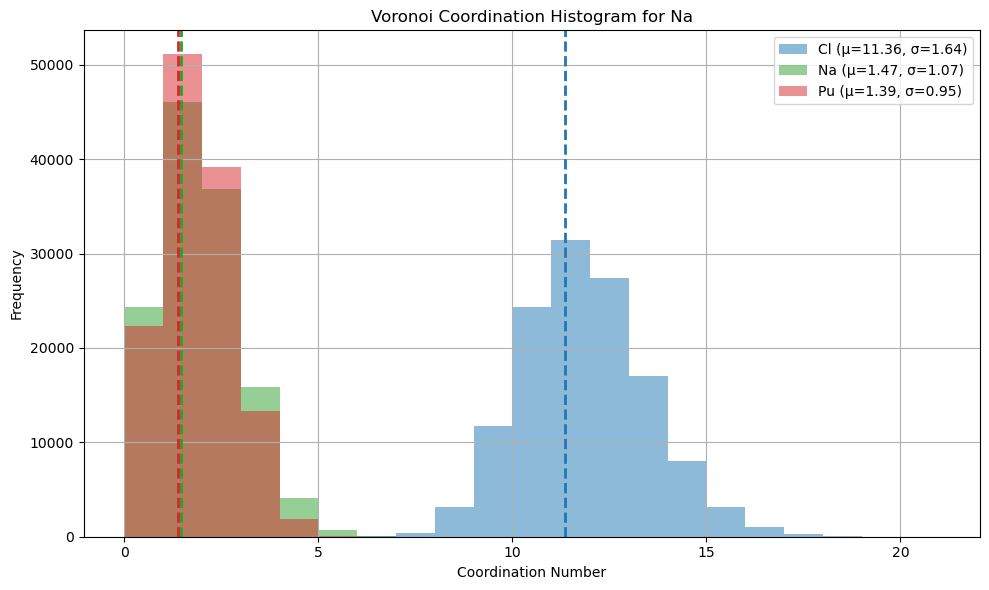


Plotting coordination histogram for Cl:


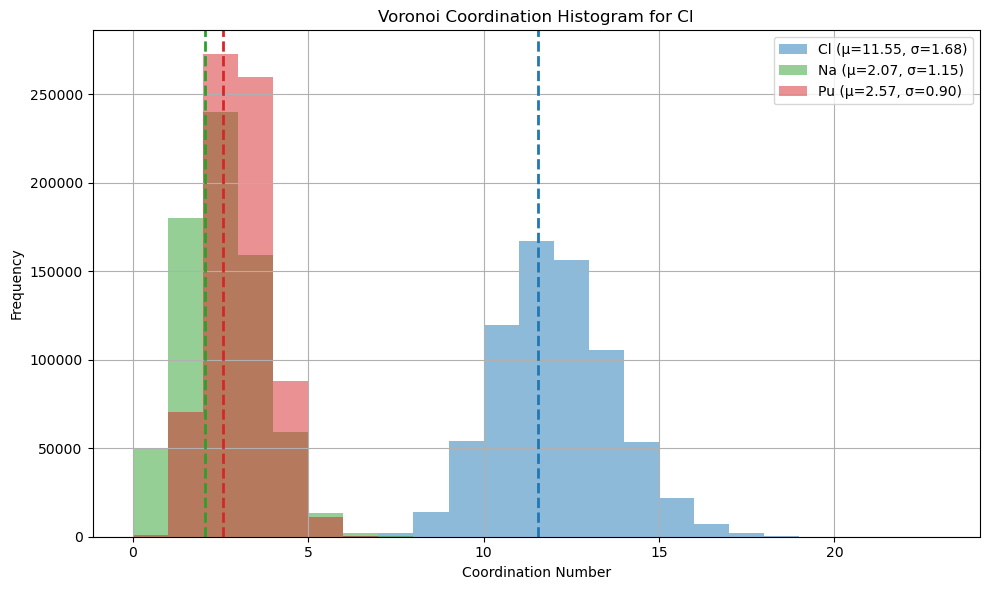


Plotting coordination histogram for Pu:


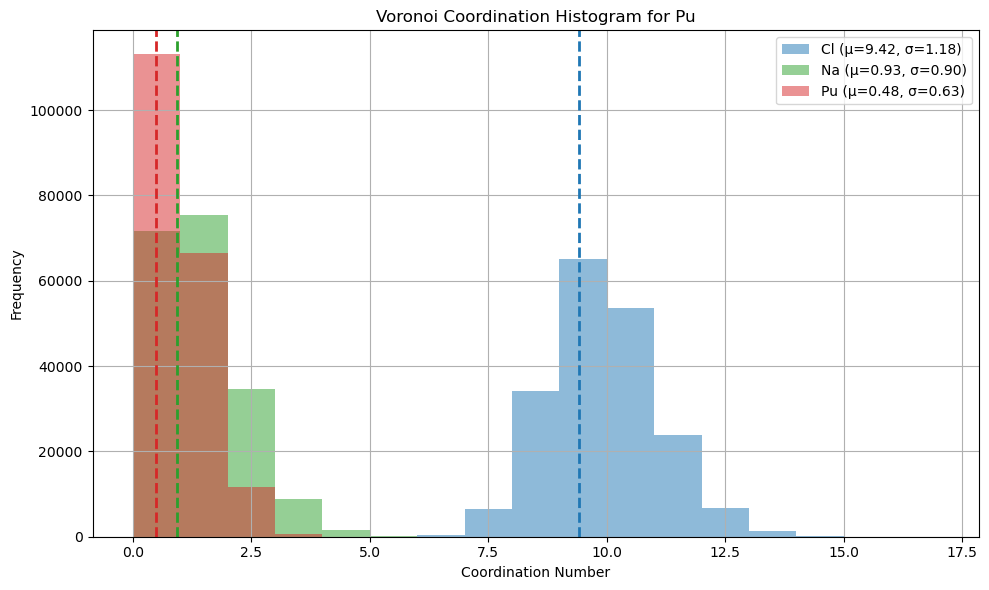

In [13]:
# Plot coordination histograms for each species
for species in at_list:
    print(f"\nPlotting coordination histogram for {species}:")
    plot_coordination_histograms(coord_data, species)



Plotting coordination histogram for Pu:


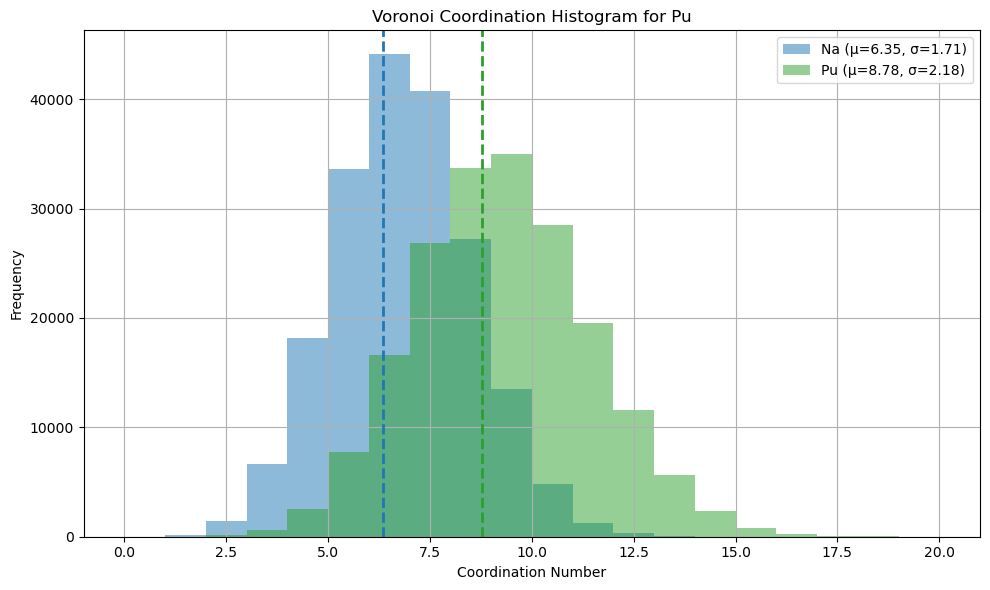


Plotting coordination histogram for Na:


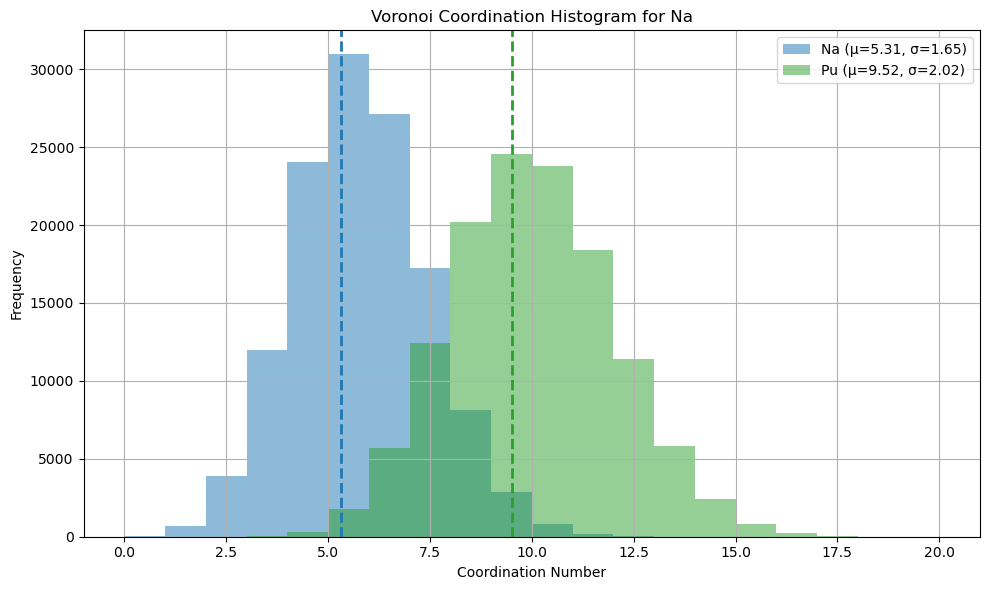

In [14]:
# Plot coordination histograms for each species
for species in ['Pu', 'Na']:
    print(f"\nPlotting coordination histogram for {species}:")
    plot_coordination_histograms(coord_data_metals, species)

In [15]:
# Build graph using Voronoi tessellations for a sample frame
sample_atoms = atomba[0]
print(f"Building Voronoi graph for sample frame with {len(sample_atoms)} atoms...")

# Build graph with different area thresholds
min_areas = [0.0, 1.0, 5.0, 10.0]
graphs = {}

for min_area in min_areas:
    print(f"Building graph with min_area = {min_area}")
    G = build_voronoi_graph(sample_atoms, min_area=min_area)
    graphs[min_area] = G
    
    # Analyze graph properties
    properties = analyze_graph_properties(G)
    print(f"  Nodes: {properties['num_nodes']}, Edges: {properties['num_edges']}")
    print(f"  Density: {properties['density']:.4f}")
    print(f"  Avg degree: {properties['avg_degree']:.2f}")
    print(f"  Connected: {properties['is_connected']}")
    if not properties['is_connected']:
        print(f"  Components: {properties['num_components']}")
        print(f"  Largest component: {properties['largest_component_fraction']:.2%}")
    print()


Building Voronoi graph for sample frame with 2048 atoms...
Building graph with min_area = 0.0
  Nodes: 2048, Edges: 15361
  Density: 0.0073
  Avg degree: 15.00
  Connected: True

Building graph with min_area = 1.0
  Nodes: 2048, Edges: 11547
  Density: 0.0055
  Avg degree: 11.28
  Connected: True

Building graph with min_area = 5.0
  Nodes: 2048, Edges: 5444
  Density: 0.0026
  Avg degree: 5.32
  Connected: True

Building graph with min_area = 10.0
  Nodes: 2048, Edges: 472
  Density: 0.0002
  Avg degree: 0.46
  Connected: False
  Components: 1577
  Largest component: 0.88%



In [16]:
# Build graph using Voronoi tessellations for a sample frame
sample_atoms = atomba[0]
print(f"Building Voronoi graph for sample frame with {len(sample_atoms)} atoms...")

# Build graph with different area thresholds
min_areas = [0.0, 1.0, 5.0, 10.0]
graphs = {}

for min_area in min_areas:
    print(f"Building graph with min_area = {min_area}")
    G = build_voronoi_graph(sample_atoms, min_area=min_area)
    graphs[min_area] = G
    
    # Analyze graph properties
    properties = analyze_graph_properties(G)
    print(f"  Nodes: {properties['num_nodes']}, Edges: {properties['num_edges']}")
    print(f"  Density: {properties['density']:.4f}")
    print(f"  Avg degree: {properties['avg_degree']:.2f}")
    print(f"  Connected: {properties['is_connected']}")
    if not properties['is_connected']:
        print(f"  Components: {properties['num_components']}")
        print(f"  Largest component: {properties['largest_component_fraction']:.2%}")
    print()


Building Voronoi graph for sample frame with 2048 atoms...
Building graph with min_area = 0.0
  Nodes: 2048, Edges: 15361
  Density: 0.0073
  Avg degree: 15.00
  Connected: True

Building graph with min_area = 1.0
  Nodes: 2048, Edges: 11547
  Density: 0.0055
  Avg degree: 11.28
  Connected: True

Building graph with min_area = 5.0
  Nodes: 2048, Edges: 5444
  Density: 0.0026
  Avg degree: 5.32
  Connected: True

Building graph with min_area = 10.0
  Nodes: 2048, Edges: 472
  Density: 0.0002
  Avg degree: 0.46
  Connected: False
  Components: 1577
  Largest component: 0.88%



In [18]:
# Build graph using Voronoi tessellations for a sample frame
sample_atoms = atomba[0]
print(f"Building Voronoi graph for sample frame with {len(sample_atoms)} atoms...")

# Build graph with different area thresholds
min_areas = [0.0, 1.0, 5.0, 10.0]
graphs_metals = {}

for min_area in min_areas:
    print(f"Building graph with min_area = {min_area}")
    G_metals = build_voronoi_graph_metals_only(sample_atoms, min_area=min_area, metal_species=['Pu', 'Na'])
    graphs_metals[min_area] = G_metals
    
    # Analyze graph properties
    properties = analyze_graph_properties(G)
    print(f"  Nodes: {properties['num_nodes']}, Edges: {properties['num_edges']}")
    print(f"  Density: {properties['density']:.4f}")
    print(f"  Avg degree: {properties['avg_degree']:.2f}")
    print(f"  Connected: {properties['is_connected']}")
    if not properties['is_connected']:
        print(f"  Components: {properties['num_components']}")
        print(f"  Largest component: {properties['largest_component_fraction']:.2%}")
    print()


Building Voronoi graph for sample frame with 2048 atoms...
Building graph with min_area = 0.0
Tessellating 640 metal atoms: {np.str_('Na'): np.int64(256), np.str_('Pu'): np.int64(384)}
Created graph with 640 nodes and 4808 edges
  Nodes: 2048, Edges: 472
  Density: 0.0002
  Avg degree: 0.46
  Connected: False
  Components: 1577
  Largest component: 0.88%

Building graph with min_area = 1.0
Tessellating 640 metal atoms: {np.str_('Na'): np.int64(256), np.str_('Pu'): np.int64(384)}
Created graph with 640 nodes and 4023 edges
  Nodes: 2048, Edges: 472
  Density: 0.0002
  Avg degree: 0.46
  Connected: False
  Components: 1577
  Largest component: 0.88%

Building graph with min_area = 5.0
Tessellating 640 metal atoms: {np.str_('Na'): np.int64(256), np.str_('Pu'): np.int64(384)}
Created graph with 640 nodes and 2922 edges
  Nodes: 2048, Edges: 472
  Density: 0.0002
  Avg degree: 0.46
  Connected: False
  Components: 1577
  Largest component: 0.88%

Building graph with min_area = 10.0
Tessella

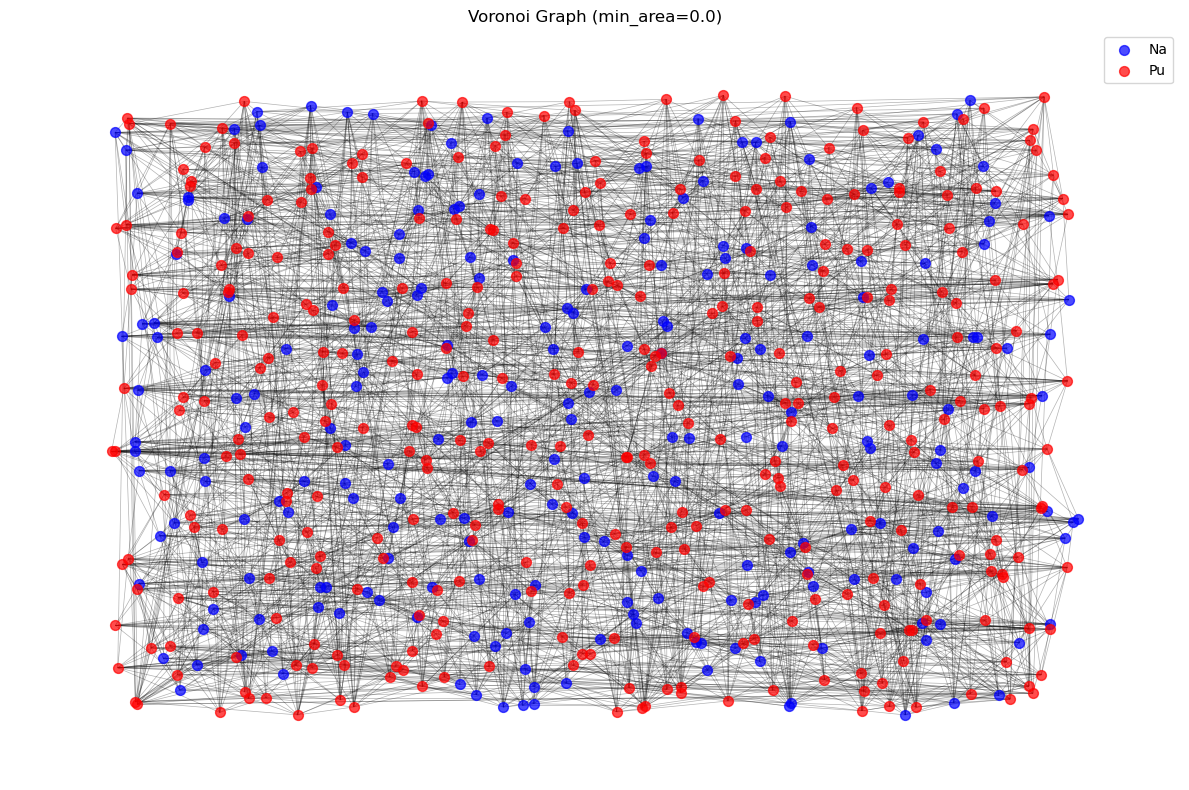

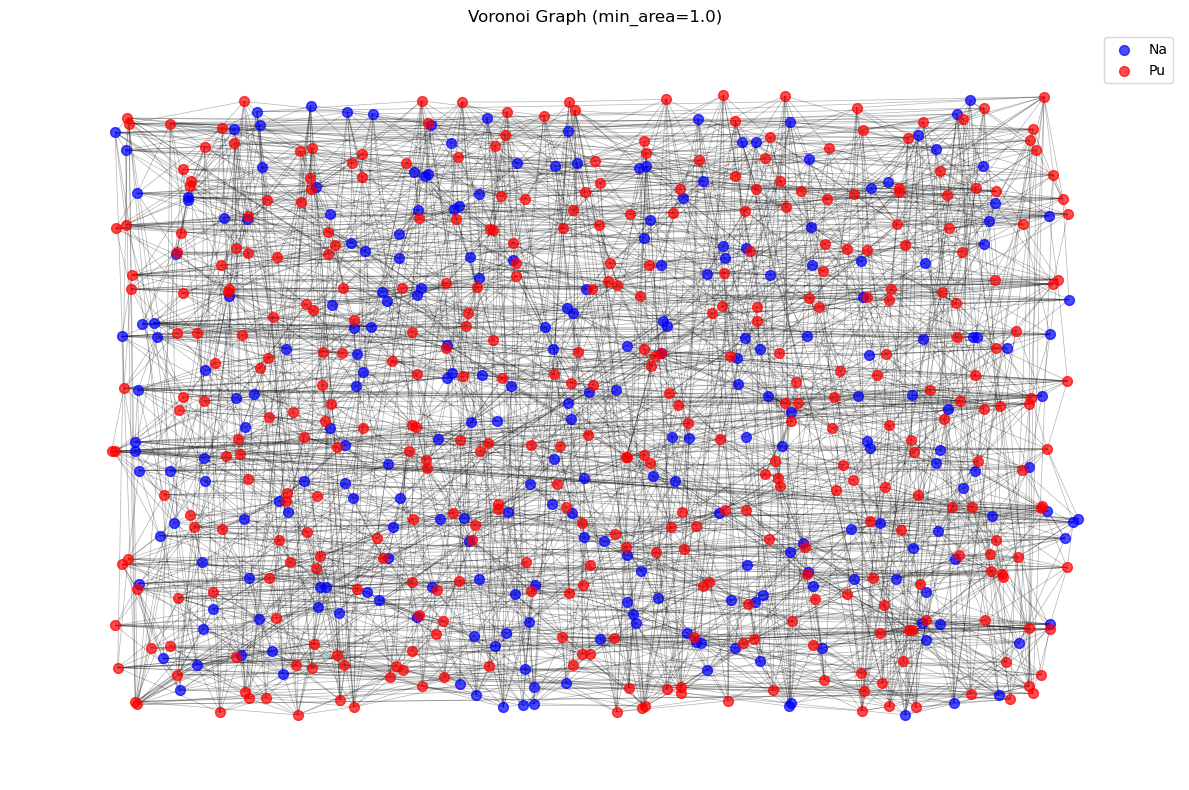

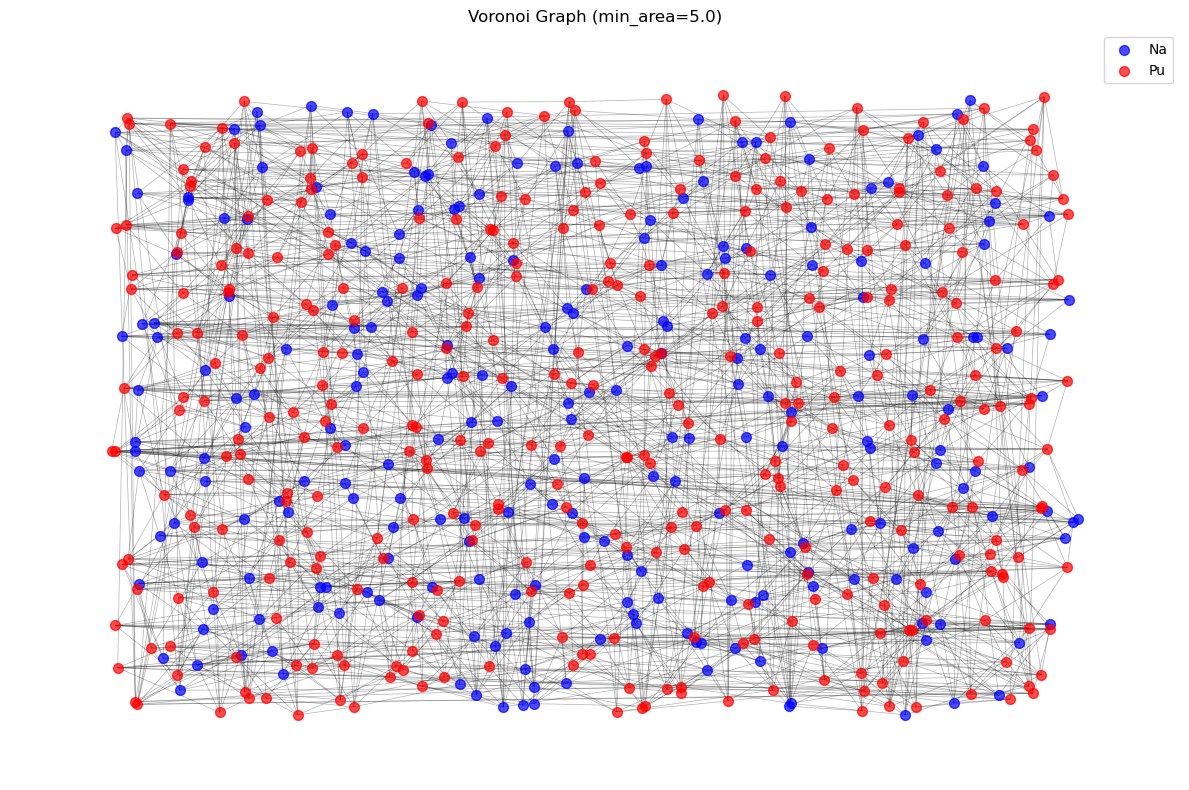

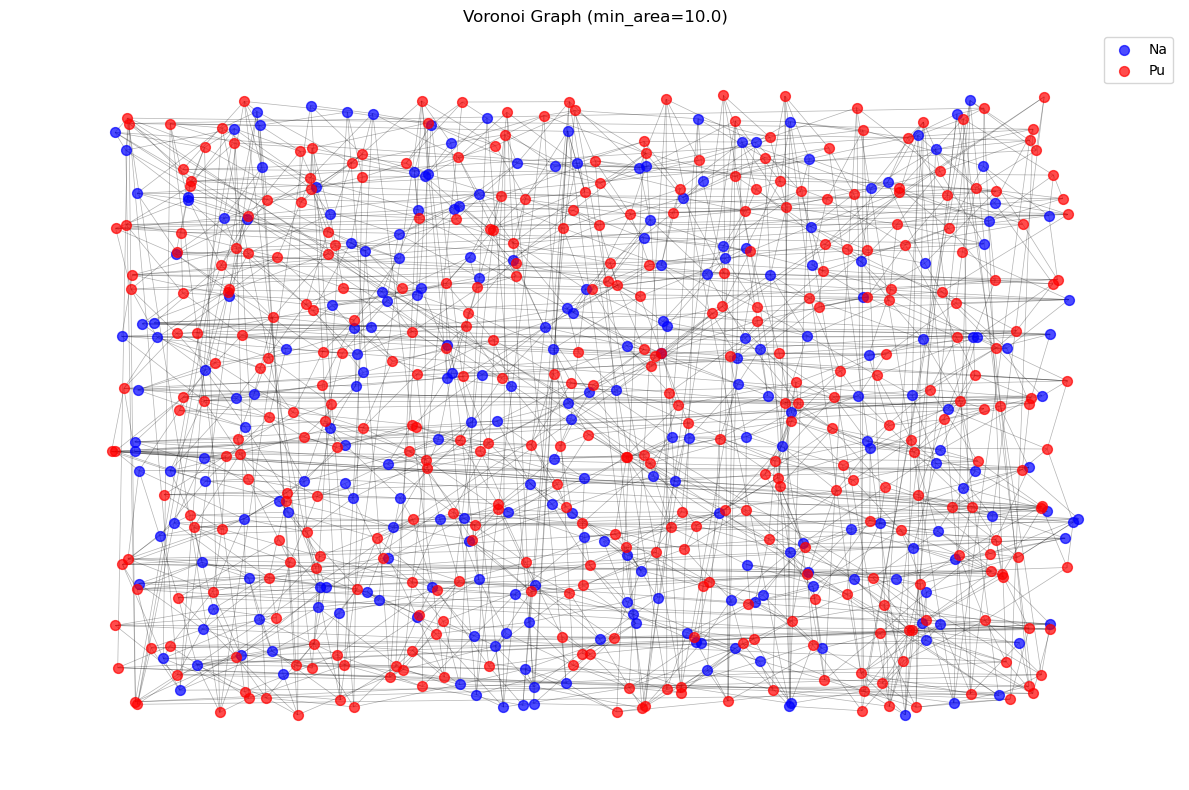

In [19]:
# Plot graph for different area thresholds
for min_area, G in graphs_metals.items():
    if G.number_of_edges() > 0:  # Only plot if graph has edges
        plot_graph_structure(G, f"Voronoi Graph (min_area={min_area})")

In [ ]:
# Analyze multiple frames to understand temporal evolution
def analyze_temporal_graph_properties(atoms_list, min_area=0.0, sample_frames=10):
    """
    Analyze graph properties over time for personality analysis.
    
    Parameters:
        atoms_list: List of ASE atoms objects
        min_area: Minimum facet area threshold
        sample_frames: Number of frames to sample
    
    Returns:
        dict: Temporal evolution of graph properties
    """
    frame_indices = np.linspace(0, len(atoms_list)-1, sample_frames, dtype=int)
    
    temporal_properties = {
        'frame_indices': frame_indices,
        'num_nodes': [],
        'num_edges': [],
        'density': [],
        'avg_degree': [],
        'is_connected': [],
        'largest_component_fraction': [],
        'avg_facet_area': []
    }
    
    for frame_idx in frame_indices:
        atoms = atoms_list[frame_idx]
        G = build_voronoi_graph(atoms, min_area=min_area)
        properties = analyze_graph_properties(G)
        
        temporal_properties['num_nodes'].append(properties['num_nodes'])
        temporal_properties['num_edges'].append(properties['num_edges'])
        temporal_properties['density'].append(properties['density'])
        temporal_properties['avg_degree'].append(properties['avg_degree'])
        temporal_properties['is_connected'].append(properties['is_connected'])
        temporal_properties['largest_component_fraction'].append(
            properties.get('largest_component_fraction', 1.0)
        )
        temporal_properties['avg_facet_area'].append(properties['avg_facet_area'])
    
    return temporal_properties

# Analyze temporal evolution
print("Analyzing temporal evolution of graph properties...")
temporal_data = analyze_temporal_graph_properties(atomba, min_area=0.0, sample_frames=20)


Analyzing temporal evolution of graph properties...


In [ ]:
# Summary and comparison with RDF-based approach
print("=== VORONOI-BASED GRAPH ANALYSIS SUMMARY ===")
print(f"Sample data: {len(atomba)} frames")
print(f"Species: {at_list}")
print(f"Average atoms per frame: {len(atomba[0])}")

print("\n=== COORDINATION ANALYSIS ===")
for species in at_list:
    total_coord = sum(len(coord_data[species][neighbor]) for neighbor in coord_data[species])
    avg_coord = np.mean([sum(coord_data[species][neighbor]) for neighbor in coord_data[species]])
    print(f"{species}: {total_coord} total coordinations, avg per frame: {avg_coord:.1f}")

print("\n=== GRAPH PROPERTIES (min_area=0.0) ===")
sample_props = analyze_graph_properties(graphs[0.0])
for key, value in sample_props.items():
    if isinstance(value, dict):
        print(f"{key}: {value}")
    else:
        print(f"{key}: {value}")

print("\n=== TEMPORAL STABILITY ===")
print(f"Graph density variation: {np.std(temporal_data['density']):.4f}")
print(f"Average degree variation: {np.std(temporal_data['avg_degree']):.2f}")
print(f"Connectivity stable: {all(temporal_data['is_connected'])}")

print("\n=== ADVANTAGES OF VORONOI APPROACH ===")
print("1. Mathematically rigorous neighbor definition")
print("2. No arbitrary cutoff distances")
print("3. Natural handling of periodic boundary conditions")
print("4. Facet areas provide bond strength information")
print("5. Works well for complex multi-component systems")


=== VORONOI-BASED GRAPH ANALYSIS SUMMARY ===
Sample data: 500 frames
Species: {'Na', 'Pu', 'Cl'}
Average atoms per frame: 2048

=== COORDINATION ANALYSIS ===
Na: 384000 total coordinations, avg per frame: 606533.0
Pu: 576000 total coordinations, avg per frame: 692522.7
Cl: 2112000 total coordinations, avg per frame: 3798412.0

=== GRAPH PROPERTIES (min_area=0.0) ===
num_nodes: 2048
num_edges: 15361
density: 0.007328273845872008
species_counts: {'Cl': 1408, 'Na': 256, 'Pu': 384}
is_connected: True
diameter: 10
radius: 8
avg_degree: 15.0009765625
std_degree: 2.767169241088388
max_degree: 24
min_degree: 8
species_avg_degrees: {'Cl': np.float64(16.252130681818183), 'Na': np.float64(14.46484375), 'Pu': np.float64(10.770833333333334)}
avg_facet_area: 3.8439900875091553
std_facet_area: 3.0938901901245117
min_facet_area: 6.076945282984525e-06
max_facet_area: 19.653356552124023

=== TEMPORAL STABILITY ===
Graph density variation: 0.0000
Average degree variation: 0.03
Connectivity stable: True



In [ ]:
# Cluster analysis using Voronoi graphs
def analyze_voronoi_clusters(atoms, min_area=0.0, metal_species=['Pu', 'Na']):
    """
    Perform cluster analysis using Voronoi tessellations for metal atoms.
    
    Parameters:
        atoms: ASE atoms object
        min_area: Minimum facet area threshold
        metal_species: List of metal species to analyze
    
    Returns:
        tuple: (cluster_sizes, cluster_ids, graph)
    """
    # Build Voronoi graph for metals only
    G = build_voronoi_graph_metals_only(atoms, min_area=min_area, metal_species=metal_species)
    
    if G.number_of_nodes() == 0:
        print("No metal atoms found!")
        return np.array([]), np.array([]), G
    
    # Find connected components (clusters)
    components = list(nx.connected_components(G))
    cluster_sizes = np.array([len(comp) for comp in components], dtype=int)
    
    # Create cluster ID array for all atoms
    cluster_ids = -np.ones(len(atoms), dtype=int)  # -1 for unclustered
    
    # Assign cluster IDs to metal atoms
    for cluster_id, component in enumerate(components):
        for atom_idx in component:
            cluster_ids[atom_idx] = cluster_id
    
    return cluster_sizes, cluster_ids, G

# Test cluster analysis on sample data
print("=== Testing Voronoi Cluster Analysis ===")
sample_atoms = atomba[0]
cluster_sizes, cluster_ids, G_clusters = analyze_voronoi_clusters(sample_atoms, min_area=0.0)

print(f"Cluster analysis results:")
print(f"Number of clusters: {len(cluster_sizes)}")
print(f"Cluster sizes: {cluster_sizes}")
print(f"Graph nodes: {G_clusters.number_of_nodes()}")
print(f"Graph edges: {G_clusters.number_of_edges()}")

if len(cluster_sizes) > 0:
    print(f"Largest cluster size: {np.max(cluster_sizes)}")
    print(f"Average cluster size: {np.mean(cluster_sizes):.2f}")
    print(f"Non-isolated metal atoms: {np.sum(cluster_ids >= 0)}")
else:
    print("No clusters found!")


In [ ]:
# Demonstrate plotting functions with Voronoi cluster analysis
print("=== Creating Voronoi-Based Cluster Visualizations ===")

# Get atom names for analysis
names = np.array(sample_atoms.get_chemical_symbols())

# 1. Plot cluster size distribution
print("1. Creating cluster size distribution plot...")
if len(cluster_sizes) > 0:
    plot_cluster_size_distribution(cluster_sizes, "Voronoi-Based Metal Cluster Size Distribution")
else:
    print("No clusters to plot!")


In [ ]:
# 2. Analyze cluster composition (Pu vs Na)
print("2. Analyzing cluster composition...")
if len(cluster_sizes) > 0:
    cluster_compositions = plot_cluster_composition_analysis(sample_atoms, cluster_ids, names)
else:
    print("No clusters to analyze!")


In [ ]:
# 3. Analyze Voronoi edge network
print("3. Analyzing Voronoi edge network...")
edge_counts = analyze_bond_network(sample_atoms, names)


In [ ]:
# 4. 3D visualization of largest clusters
print("4. Creating 3D cluster visualization...")
if len(cluster_sizes) > 0:
    plot_3d_cluster_visualization(sample_atoms, cluster_ids, names, max_clusters=10)
else:
    print("No clusters to visualize!")


In [ ]:
# 5. Compare different area thresholds for cluster analysis
print("5. Comparing different area thresholds...")

min_areas = [0.0, 1.0, 5.0, 10.0]
threshold_results = {}

for min_area in min_areas:
    print(f"\nAnalyzing with min_area = {min_area}")
    sizes, ids, G = analyze_voronoi_clusters(sample_atoms, min_area=min_area)
    threshold_results[min_area] = {
        'sizes': sizes,
        'ids': ids,
        'graph': G
    }
    
    if len(sizes) > 0:
        print(f"  Clusters: {len(sizes)}, Largest: {np.max(sizes)}, Avg: {np.mean(sizes):.2f}")
    else:
        print(f"  No clusters found")

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (min_area, results) in enumerate(threshold_results.items()):
    if i < len(axes) and len(results['sizes']) > 0:
        axes[i].hist(results['sizes'], bins=20, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'min_area = {min_area}')
        axes[i].set_xlabel('Cluster Size')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        axes[i].text(0.7, 0.9, f'Clusters: {len(results["sizes"])}\nLargest: {np.max(results["sizes"])}', 
                    transform=axes[i].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

plt.tight_layout()
plt.show()

print("\n=== SUMMARY: Voronoi vs RDF-Based Analysis ===")
print("Voronoi advantages:")
print("- No arbitrary cutoff distances")
print("- Mathematically rigorous neighbor definition")
print("- Natural handling of periodic boundary conditions")
print("- Facet areas provide bond strength information")
print("- Works well for complex multi-component systems")

print("\nRDF advantages:")
print("- Physically intuitive bond definition")
print("- Well-established in literature")
print("- Easy to interpret and validate")
print("- Can be tuned based on experimental data")
